In [1]:
#!python setup.py build_ext --inplace

In [2]:
import numpy as np
import bayesflow as bf
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from simulator import retest2_config_two_trial as sim_v2

2023-11-07 17:53:15.239423: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 17:53:15.241036: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 17:53:15.275300: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 17:53:15.275996: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 17:53:15.869498: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
import random 
random.seed(12)

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
def draw_prior():
    """Generates random draws from the prior."""
    v1 =np.random.uniform(low=0.0,high=5.0)
    v2 =np.random.uniform(low=-5.0,high=0.0)
    zr =np.random.uniform(low=0.3,high=0.7)
    #zr =np.random.uniform(low=0.5,high=0.5)

    a  =np.random.uniform(low=0.6,high=3.0)
    ndt =np.random.uniform(low=0.1,high=0.7)
    sndt =np.random.uniform(low=0.0,high=0.3)
    alpha =np.random.uniform(low=1.0,high=2.0)

    return np.array([v1,v2,zr,a, ndt,sndt,alpha])

In [6]:
def prior_N(n_min=50, n_max=500):
    """A prior fo]r the number of observation (will be called internally at each backprop step)."""
    return  np.random.randint(n_min, n_max+1, 2)

In [7]:
prior = bf.simulation.Prior(prior_fun=draw_prior,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])
var_num_obs = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)
simulator = bf.simulation.Simulator(simulator_fun=sim_v2.simulate_diffusion_2_conds, context_generator=var_num_obs)
generative_model = bf.simulation.GenerativeModel(prior,simulator,name='v2_equiv')

Performing 2 pilot runs with the v2_equiv model...
Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 7)
Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 264, 2)
No optional prior non-batchable context provided.
No optional prior batchable context provided.
Shape of simulation non-batchable context: (2,)
No optional simulation batchable context provided.


In [8]:
prior_means, prior_stds = prior.estimate_means_and_stds()
#Prior Checking
#f = prior.plot_prior2d()

In [9]:
def configurator(sim_dict):
    """Configures the outputs of a generative model for interaction with 
    BayesFlow modules."""
    
    out = dict()
    # These will be passed through the summary network. In this case,
    # it's just the data, but it can be other stuff as well.
    data = sim_dict['sim_data'].astype(np.float32)
    
    # Extract prior draws and z-standardize with previously computed means
    params = ((sim_dict['prior_draws'].astype(np.float32)) - prior_means) / prior_stds
    #params = (params - prior_means) / prior_stds
    
    
    # Remove a batch if it contains nan, inf or -inf
    idx_keep = np.all(np.isfinite(data), axis=(1, 2))
    if not np.all(idx_keep):
        print('Invalid value encountered...removing from batch')
        
    out['summary_conditions'] = data[idx_keep]
    out['parameters'] = params[idx_keep]

    
    
    
    
    # These will be concatenated to the outputs of the summary network
    # Convert N to log N since neural nets cant deal well with large numbers
    N = np.log(sim_dict['sim_non_batchable_context'])
    # Repeat N for each sim (since shared across batch), notice the
    # extra dimension needed
    N_vec = N * np.ones((data.shape[0], 1), dtype=np.float32)
    out['direct_conditions'] = N_vec
    return out


In [10]:
sim_dict= generative_model(32)

In [11]:
configurator(sim_dict)['summary_conditions'].shape

(32, 665, 2)

In [12]:
sim_dict['sim_non_batchable_context']

array([231, 434])

In [13]:
sim_dict['sim_data'].shape[0]

32

In [14]:
sim_dict['sim_data'].shape

(32, 665, 2)

In [15]:
N = np.log(sim_dict['sim_non_batchable_context'])
N

array([5.44241771, 6.07304453])

In [16]:
%%time
# Quick test
_ = configurator(generative_model(32))


CPU times: user 1.13 s, sys: 3.14 ms, total: 1.13 s
Wall time: 1.13 s


In [17]:
summary_net = bf.networks.InvariantNetwork(summary_dim=64,num_equiv=3)
inference_net = bf.networks.InvertibleNetwork(num_params=len(prior.param_names),num_coupling_layers=6)
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net, name='v2_equive')




/tmp/ipykernel_431359/208481748.py:1: DeprecationWarning: InvariantNetwork will be deprecated. at some point. Use ``DeepSet`` instead.
  summary_net = bf.networks.InvariantNetwork(summary_dim=64,num_equiv=3)


In [18]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer, 
    generative_model=generative_model, 
    configurator=configurator,
    checkpoint_path='./checkpoints/retest_v2_config_RandTri')

Loaded loss history from ./checkpoints/retest_v2_config_RandTri/history_200.pkl.
Loaded simulation memory from ./checkpoints/retest_v2_config_RandTri/memory.pkl
Networks loaded from ./checkpoints/retest_v2_config_RandTri/ckpt-200
Performing a consistency check with provided components...
Done.


In [19]:
amortizer.summary()

Model: "v2_equive"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 invertible_network (Invert  multiple                  623868    
 ibleNetwork)                                                    
                                                                 
 invariant_network (Invaria  multiple                  100032    
 ntNetwork)                                                      
                                                                 
Total params: 723900 (2.76 MB)
Trainable params: 723816 (2.76 MB)
Non-trainable params: 84 (336.00 Byte)
_________________________________________________________________


In [20]:
import pandas as pd
import glob
folder_path = './DATA_Lerch_Voss/Study1_LDT_RMT'
file_list = np.array(glob.glob(folder_path + "/*.dat"))
main_dataframe = pd.DataFrame(pd.read_table(file_list[0]))

In [22]:
file_list[4
]

'./DATA_Lerch_Voss/Study1_LDT_RMT/1004_class_pictures_part_1.dat'

In [23]:
import os
import glob

# Define the base directory where the data is stored
base_dir = './DATA_Lerch_Voss/Study1_LDT_RMT'

# Define the tasks, parameters, and sessions
tasks = ['class_words', 'class_pictures']
sessions = ['part_1', 'part_2']

# Initialize a dictionary to store the organized data
data_dict = {task: {session: [] for session in sessions} for task in tasks}

# Loop over the tasks and sessions to organize the data
for task in tasks:
    for session in sessions:
        # Define the pattern to search for data files
        search_pattern = os.path.join(base_dir, f'*_{task}_{session}.dat')
        
        # Get the list of data files that match the pattern
        data_files = glob.glob(search_pattern)
        
        # Sort the data files by participant ID
        data_files.sort(key=lambda x: int(os.path.basename(x).split('_')[0]))
        
        # Add the sorted data files to the data dictionary
        data_dict[task][session] = data_files

# Now, data_dict contains the organized data files
print("Organized Data:")
print(data_dict)


Organized Data:
{'class_words': {'part_1': ['./DATA_Lerch_Voss/Study1_LDT_RMT/001_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/002_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/003_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/004_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/005_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/007_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/008_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/009_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/010_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/011_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/012_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/013_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/014_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/015_class_words_part_1.dat', './DATA_Lerch_Voss/Study1_LDT_RMT/016_class_words_part_1.dat', './DATA_Ler

In [21]:
#function to refine the data in accord with the Lerch_Voss_2017
def refine_data_RT(file_name):
    refined_df = pd.read_csv(file_name, sep='\s+|\s+')
    refined_df = refined_df[refined_df['RT']>200]
    refined_df = refined_df[refined_df['RT']<2500]
    refined_df['RT'] = refined_df['RT']/1000

    return refined_df

In [22]:
#Function took data and makes it compatiable with the model  


def model_compatiabel_data (df):
    # Firs change value of error respose to negative 
    df.loc[df['acc']==0, 'RT'] *= -1

    # multiply all the RTs in second condition by -1

    df.loc[df['targ_cat']==1, 'RT'] *= -1
    #Making data suitable for model
    rts = np.array(df['RT'])
    cond_arr = np.array(df['targ_cat'])
    x = np.stack((rts, cond_arr), axis=1)
    return x


    

In [26]:
df=refine_data_RT(file_list[0])
np.array(df[['RT','acc']])
data_rts = model_compatiabel_data(df)
condition_1=data_rts[data_rts[:,1]==0][:,0]
condition_2=data_rts[data_rts[:,1]==1][:,0]
condition_2


/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')


array([-1.346, -0.93 , -1.234, -0.858, -0.859, -0.858, -0.914, -0.802,
       -0.906, -1.026, -0.771, -0.85 , -0.634, -0.635, -0.682, -0.611,
       -0.835, -0.795, -0.601, -0.658, -0.649, -0.739, -0.643, -0.617,
       -0.706, -0.691, -0.571, -0.737,  0.834, -0.586, -0.595, -0.587,
       -0.699, -0.858,  0.657, -0.61 ,  0.922, -0.594, -0.619, -1.331,
       -1.219, -1.347, -0.666, -0.674, -0.882, -1.731, -0.691, -0.786,
       -0.682, -0.986, -0.811, -0.667, -0.723, -1.089, -0.611, -0.714,
       -0.809, -0.882, -0.706, -0.755, -1.395, -0.89 , -1.162, -0.882,
       -0.938, -0.683, -0.626,  0.891, -0.649, -0.675, -0.618, -0.715,
       -0.882, -0.586, -0.874, -0.834, -1.243, -0.587, -0.595, -0.698,
       -0.786, -0.722, -0.595,  0.667, -0.635, -0.803, -1.648, -0.834,
       -0.69 , -0.722, -0.851, -1.291, -0.779, -1.13 , -0.819, -1.115,
       -1.162, -0.627, -0.874,  0.585, -0.522, -0.674, -0.554,  0.57 ,
       -0.634, -0.506, -0.595, -0.722, -0.722, -0.626, -0.778, -1.147,
      

In [27]:
for task, sessions in data_dict.items():
    for session, files in sessions.items():
        for file in files:
            # Load data
            #raw_data = load_data(file)  # Define load_data() to read the .dat file
            print(file)
            # Clean data
            cleaned_data = refine_data_RT(file)
            
            # Make data compatible with the model
            model_data = model_compatiabel_data(cleaned_data)
            
            # Save or process the model data as needed
            #save_model_data(task, session, file, model_data)  # Define save_model_data() to save the processed data


/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/001_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/002_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/003_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/004_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/005_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/007_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/008_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/009_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/010_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/011_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/012_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/013_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/014_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/015_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/016_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/017_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/018_cla

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/1015_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1016_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1017_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1018_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1019_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1020_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1021_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1022_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1023_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1024_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1025_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1026_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1027_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2001_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2002_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2003_class_words_part_1.dat
./DATA_Lerch_Voss/Study1

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/3005_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3006_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3007_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3008_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3009_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3010_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3011_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3012_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3013_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3015_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3016_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3017_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3018_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3019_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3020_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3021_class_words_part_1.dat
./DATA_Lerch_Voss/Study1

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/4013_class_words_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/001_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/002_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/003_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/004_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/005_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/007_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/008_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/009_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/010_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/011_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/012_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/013_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/014_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/015_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/016_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/017_cl

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/1016_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1017_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1018_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1019_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1020_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1021_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1022_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1023_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1024_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1025_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1026_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1027_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2001_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2002_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2003_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2004_class_words_part_2.dat
./DATA_Lerch_Voss/Study1

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/3005_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3006_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3007_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3008_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3009_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3010_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3011_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3012_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3013_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3015_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3016_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3017_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3018_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3019_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3020_class_words_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3021_class_words_part_2.dat
./DATA_Lerch_Voss/Study1

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/001_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/002_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/003_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/004_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/005_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/007_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/008_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/009_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/010_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/011_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/012_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/013_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/014_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/015_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/016_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/017_class_pictures_par

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/1020_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1021_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1022_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1023_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1024_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1025_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1026_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1027_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2001_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2002_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2003_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2004_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2005_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2006_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2007_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2008_cl

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/3013_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3015_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3016_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3017_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3018_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3019_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3020_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3021_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3022_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3023_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3024_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3025_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3026_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3027_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4001_class_pictures_part_1.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4002_cl

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/014_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/015_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/016_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/017_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/018_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/019_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/020_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1001_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1002_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1003_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1004_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1005_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1006_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1007_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1008_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/1009_class_pic

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/2004_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2005_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2006_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2007_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2008_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2009_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2010_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2011_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2012_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2013_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2014_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2015_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2016_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2017_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2018_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/2019_cl

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

./DATA_Lerch_Voss/Study1_LDT_RMT/3023_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3024_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3025_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3026_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/3027_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4001_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4002_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4003_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4004_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4005_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4006_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4007_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4008_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4009_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4010_class_pictures_part_2.dat
./DATA_Lerch_Voss/Study1_LDT_RMT/4011_cl

/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

In [28]:
#f = bf.diagnostics.plot_posterior_2d(post_samples,param_names=prior.param_names)

In [29]:
#f = bf.diagnostics.plot_posterior_2d(post_samples, prior=prior)

In [32]:
list_v1_1 = []
list_v1_2 = []

list_v2_1 = []
list_v2_2 = []

list_zr_1= []
list_zr_2= []

list_a_1 = []
list_a_2 = []

list_ndt_1 = []
list_ndt_2 = []

list_sndt_1 = []
list_sndt_2 = []

list_alpha_1 = []
list_alpha_2 = []

list_rt_1 = []
list_rt_2 = []

list_accuracy_percentage_1 = []
list_accuracy_percentage_2 = []


list_accuracy_percentage_2 = []

participant_ids = []






for i in file_list : 
    if 'words_part_1' in i :
        file_name_1 = i.rsplit('/',1)[-1]
        participant_s1 = file_name_1.rsplit('_',5)[0]
        for j in file_list :
            if 'words_part_2' in j :
                file_name_2 = j.rsplit('/',1)[-1]
                participant_s2 = file_name_2.rsplit('_',5)[0]
                if participant_s1 == participant_s2 :
                    participant_ids.append(participant_s1)
                    df_1=refine_data_RT(i)
                    df_2=refine_data_RT(j)
                    accuracy_percentage_1 = df_1['acc'].mean()
                    accuracy_percentage_2 = df_2['acc'].mean()
                    
                    list_accuracy_percentage_1.append(accuracy_percentage_1)
                    list_accuracy_percentage_2.append(accuracy_percentage_1)
                    

                    

                    
                    data_rts_1=np.array(model_compatiabel_data(df_1))
                    list_rt_1.append(data_rts_1)
                    out={}
                    
                    out['summary_conditions'] = data_rts_1.reshape( 1, data_rts_1.shape[0],2)
                    non_batch_context=np.array([data_rts_1[data_rts_1[:,1]==1].shape[0],data_rts_1[data_rts_1[:,1]==0].shape[0]])
                    N = np.log(non_batch_context)
                    N_vec = N * np.ones((1, 1), dtype=np.float32)
                    out['direct_conditions'] = N_vec
                    
                    param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']

                    
                    posterior_draws_1 = amortizer.sample(out,n_samples=2000)
                    post_samples_1 = prior_means + posterior_draws_1 * prior_stds
                    
                    v1_1=post_samples_1[:,0]
                    list_v1_1.append(v1_1)

                    v2_1=post_samples_1[:,1]
                    list_v2_1.append(v2_1)
                    
                    zr_1=post_samples_1[:,2]
                    list_zr_1.append(zr_1)

                    a_1=post_samples_1[:,3]
                    list_a_1.append(a_1)

                    ndt_1=post_samples_1[:,4]
                    list_ndt_1.append(ndt_1)

                    sndt_1=post_samples_1[:,5]
                    list_sndt_1.append(sndt_1)

                    alpha_1=post_samples_1[:,6]
                    list_alpha_1.append(alpha_1)
                    
                    
                    
                                        

    
                    data_rts_2=np.array(model_compatiabel_data(df_2))
                    list_rt_2.append(data_rts_2)


    
                    #considering the configurator 
                    out={}
                    
                    out['summary_conditions'] = data_rts_2.reshape( 1, data_rts_2.shape[0],2)
                    non_batch_context=np.array([data_rts_2[data_rts_2[:,1]==1].shape[0],data_rts_2[data_rts_2[:,1]==0].shape[0]])
                    N = np.log(non_batch_context)
                    N_vec = N * np.ones((1, 1), dtype=np.float32)
                    out['direct_conditions'] = N_vec
                    
                    
                    
                    posterior_draws_2 = amortizer.sample(out,n_samples=2000)
                    post_samples_2 = prior_means + posterior_draws_2 * prior_stds
                    
                    v1_2 = post_samples_2[:,0]
                    list_v1_2.append(v1_2)

                    v2_2=post_samples_2[:,1]
                    list_v2_2.append(v2_2)
                    
                    zr_2=post_samples_2[:,2]
                    list_zr_2.append(zr_2)

                    a_2=post_samples_2[:,3]
                    list_a_2.append(a_2)

                    ndt_2=post_samples_2[:,4]
                    list_ndt_2.append(ndt_2)

                    sndt_2=post_samples_2[:,5]
                    list_sndt_2.append(sndt_2)

                    alpha_2=post_samples_2[:,6]
                    list_alpha_2.append(alpha_2)
                    
                    

np.save('./####posterior_word/participant_ids.npy', participant_ids)

np.save('./####posterior_word/list_accuracy_percentage_1.npy', list_accuracy_percentage_1)
np.save('./####posterior_word/list_accuracy_percentage_2.npy', list_accuracy_percentage_2)

np.save('./####posterior_word/list_rt_1.npy', list_rt_1)
np.save('./####posterior_word/list_rt_2.npy', list_rt_2)
                   
                                        
np.save('./####posterior_word/list_v1_1.npy', list_v1_1)
np.save('./####posterior_word/list_v1_2.npy', list_v1_2)

np.save('./####posterior_word/list_v2_1.npy', list_v2_1)
np.save('./####posterior_word/list_v2_2.npy', list_v2_2)

np.save('./####posterior_word/list_zr_1.npy', list_zr_1)
np.save('./####posterior_word/list_zr_2.npy', list_zr_2)

np.save('./####posterior_word/list_a_1.npy', list_a_1)
np.save('./####posterior_word/list_a_2.npy', list_a_2)

np.save('./####posterior_word/list_ndt_1.npy', list_ndt_1)
np.save('./####posterior_word/list_ndt_2.npy', list_ndt_2)

np.save('./####posterior_word/list_sndt_1.npy', list_sndt_1)
np.save('./####posterior_word/list_sndt_2.npy', list_sndt_2)

np.save('./####posterior_word/list_alpha_1.npy', list_alpha_1)
np.save('./####posterior_word/list_alpha_2.npy', list_alpha_2)





    



/tmp/ipykernel_426149/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_426149/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_426149/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

# PICTURE

In [30]:
pic_v1_1 = []
pic_v1_2 = []

pic_v2_1 = []
pic_v2_2 = []

pic_zr_1= []
pic_zr_2= []

pic_a_1 = []
pic_a_2 = []

pic_ndt_1 = []
pic_ndt_2 = []

pic_sndt_1 = []
pic_sndt_2 = []

pic_alpha_1 = []
pic_alpha_2 = []

pic_rt_1 = []
pic_rt_2 = []

pic_accuracy_percentage_1 = []
pic_accuracy_percentage_2 = []

pic_participant_ids = []






for i in file_list : 
    if 'pictures_part_1' in i :
        file_name_1 = i.rsplit('/',1)[-1]
        participant_s1 = file_name_1.rsplit('_',5)[0]
        for j in file_list :
            if 'pictures_part_2' in j :
                file_name_2 = j.rsplit('/',1)[-1]
                participant_s2 = file_name_2.rsplit('_',5)[0]
                if participant_s1 == participant_s2 :
                    pic_participant_ids.append(participant_s1)

                    df_1=refine_data_RT(i)
                    df_1 = df_1.drop(df_1.loc[df_1['trl_block']==0].index)
                    df_2=refine_data_RT(j)
                    df_2 = df_2.drop(df_2.loc[df_2['trl_block']==0].index)
                    
                    
                    accuracy_percentage_1 = df_1['acc'].mean()
                    accuracy_percentage_2 = df_2['acc'].mean()
                    pic_accuracy_percentage_1.append(accuracy_percentage_1)
                    pic_accuracy_percentage_2.append(accuracy_percentage_1)



                    

                    
                    data_rts_1=np.array(model_compatiabel_data(df_1))
                    pic_rt_1.append(data_rts_1)
                    out={}
                    
                    out['summary_conditions'] = data_rts_1.reshape( 1, data_rts_1.shape[0],2)
                    non_batch_context=np.array([data_rts_1[data_rts_1[:,1]==1].shape[0],data_rts_1[data_rts_1[:,1]==0].shape[0]])
                    N = np.log(non_batch_context)
                    N_vec = N * np.ones((1, 1), dtype=np.float32)
                    out['direct_conditions'] = N_vec
                    
                    param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']

                    
                    posterior_draws_1 = amortizer.sample(out,n_samples=2000)
                    post_samples_1 = prior_means + posterior_draws_1 * prior_stds
                    
                    v1_1=post_samples_1[:,0]
                    pic_v1_1.append(v1_1)

                    v2_1=post_samples_1[:,1]
                    pic_v2_1.append(v2_1)
                    
                    zr_1=post_samples_1[:,2]
                    pic_zr_1.append(zr_1)

                    a_1=post_samples_1[:,3]
                    pic_a_1.append(a_1)

                    ndt_1=post_samples_1[:,4]
                    pic_ndt_1.append(ndt_1)

                    sndt_1=post_samples_1[:,5]
                    pic_sndt_1.append(sndt_1)

                    alpha_1=post_samples_1[:,6]
                    pic_alpha_1.append(alpha_1)
                    
                    
                    
                                        

    
                    data_rts_2=np.array(model_compatiabel_data(df_2))
                    pic_rt_2.append(data_rts_2)


    
                    #considering the configurator 
                    out={}
                    
                    out['summary_conditions'] = data_rts_2.reshape( 1, data_rts_2.shape[0],2)
                    non_batch_context=np.array([data_rts_2[data_rts_2[:,1]==1].shape[0],data_rts_2[data_rts_2[:,1]==0].shape[0]])
                    N = np.log(non_batch_context)
                    N_vec = N * np.ones((1, 1), dtype=np.float32)
                    out['direct_conditions'] = N_vec
                    
                    
                    
                    posterior_draws_2 = amortizer.sample(out,n_samples=2000)
                    post_samples_2 = prior_means + posterior_draws_2 * prior_stds
                    
                    v1_2 = post_samples_2[:,0]
                    pic_v1_2.append(v1_2)

                    v2_2=post_samples_2[:,1]
                    pic_v2_2.append(v2_2)
                    
                    zr_2=post_samples_2[:,2]
                    pic_zr_2.append(zr_2)

                    a_2=post_samples_2[:,3]
                    pic_a_2.append(a_2)

                    ndt_2=post_samples_2[:,4]
                    pic_ndt_2.append(ndt_2)

                    sndt_2=post_samples_2[:,5]
                    pic_sndt_2.append(sndt_2)

                    alpha_2=post_samples_2[:,6]
                    pic_alpha_2.append(alpha_2)
                    
                    





np.save('./####posterior_pic_2/pic_participant_ids.npy', pic_participant_ids)
                                       
np.save('./####posterior_pic_2/pic_v1_1.npy', pic_v1_1)
np.save('./####posterior_pic_2/pic_v1_2.npy', pic_v1_2)

np.save('./####posterior_pic_2/pic_v2_1.npy', pic_v2_1)
np.save('./####posterior_pic_2/pic_v2_2.npy', pic_v2_2)

np.save('./####posterior_pic_2/pic_zr_1.npy', pic_zr_1)
np.save('./####posterior_pic_2/pic_zr_2.npy', pic_zr_2)

np.save('./####posterior_pic_2/pic_a_1.npy', pic_a_1)
np.save('./####posterior_pic_2/pic_a_2.npy', pic_a_2)

np.save('./####posterior_pic_2/pic_ndt_1.npy', pic_ndt_1)
np.save('./####posterior_pic_2/pic_ndt_2.npy', pic_ndt_2)

np.save('./####posterior_pic_2/pic_sndt_1.npy', pic_sndt_1)
np.save('./####posterior_pic_2/pic_sndt_2.npy', pic_sndt_2)

np.save('./####posterior_pic_2/pic_alpha_1.npy', pic_alpha_1)
np.save('./####posterior_pic_2/pic_alpha_2.npy', pic_alpha_2)


np.save('./####posterior_pic_2/pic_rt_1.npy', pic_rt_1)
np.save('./####posterior_pic_2/pic_rt_2.npy', pic_rt_2)

np.save('./####posterior_pic_2/pic_accuracy_percentage_1.npy', pic_accuracy_percentage_1)
np.save('./####posterior_pic_2/pic_accuracy_percentage_2.npy', pic_accuracy_percentage_2)




    



/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_428336/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

In [ ]:
#list_accuracy_percentage_1 = []
#list_accuracy_percentage_2 = []

accuracy_percentage_1 = df_1['acc'].mean()
accuracy_percentage_2 = df_2['acc'].mean()

list_accuracy_percentage_1.append(accuracy_percentage_1)
list_accuracy_percentage_2.append(accuracy_percentage_1)

#np.save('list_accuracy_percentage_1.npy', list_accuracy_percentage_1)
#np.save('list_accuracy_percentage_2.npy', list_accuracy_percentage_2)



In [79]:


list_rt_session_2_condition_1 = []
list_rt_session_2_condition_2 = []
list_rt_session_1_condition_1 = []
list_rt_session_1_condition_2 = []



list_accuracy_percentage_1 = []
list_accuracy_percentage_2 = []

dict_session_1 = {}
dict_session_2 = {}

for i in file_list : 
    if 'words_part_1' in i :
        file_name_1 = i.rsplit('/',1)[-1]
        participant_s1 = file_name_1.rsplit('_',5)[0]
        for j in file_list :
            if 'words_part_2' in j :
                file_name_2 = j.rsplit('/',1)[-1]
                participant_s2 = file_name_2.rsplit('_',5)[0]
                if participant_s1 == participant_s2 :
                    df_1=refine_data_RT(i)
                    df_2=refine_data_RT(j)
                    accuracy_percentage_1 = df_1['acc'].mean()
                    accuracy_percentage_2 = df_2['acc'].mean()

                    list_accuracy_percentage_1.append(accuracy_percentage_1)
                    list_accuracy_percentage_2.append(accuracy_percentage_1)

                    #session one
                    data_rts_1=model_compatiabel_data(df_1)

                    dict_session_1[participant_s1] = data_rts_1
                    
                    session_1_condition_1=data_rts_1[data_rts_1[:,1]==0][:,0]
                    list_rt_session_1_condition_1.append(session_1_condition_1)

                    
                    session_1_condition_2=data_rts_1[data_rts_1[:,1]==1][:,0]
                    list_rt_session_1_condition_2.append(session_1_condition_2)
                    
                    #session two
                    data_rts_2=model_compatiabel_data(df_2)
                    dict_session_2[participant_s2] = data_rts_2

                    
                    session_2_condition_1=data_rts_2[data_rts_2[:,1]==0][:,0]
                    list_rt_session_2_condition_1.append(session_2_condition_1)
            
                    session_2_condition_2=data_rts_2[data_rts_2[:,1]==1][:,0]
                    list_rt_session_2_condition_2.append(session_2_condition_2)
                    

np.save('list_rt_session_1_condition_1.npy', list_rt_session_1_condition_1, allow_pickle=True)
np.save('list_rt_session_1_condition_2.npy', list_rt_session_1_condition_2,  allow_pickle=True)
np.save('list_rt_session_2_condition_1.npy', list_rt_session_2_condition_1, allow_pickle=True)
np.save('list_rt_session_2_condition_2.npy', list_rt_session_2_condition_2, allow_pickle=True)
#np.save('list_accuracy_percentage_1.npy', list_accuracy_percentage_1)
#np.save('list_accuracy_percentage_2.npy', list_accuracy_percentage_2)


    



/tmp/ipykernel_408329/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_408329/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ipykernel_408329/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')
/tmp/ip

In [81]:
rt_session_1=pd.DataFrame([dict_session_1])
rt_session_2=pd.DataFrame([dict_session_2])
rt_session_1.to_csv('rt_session_1.csv')
rt_session_2.to_csv('rt_session_2.csv')

In [82]:
pd.read_csv('rt_session_1.csv')


,Unnamed: 0,3024,2005,1027,1006,4004,2003,1018,4002,1014,...,1005,3012,1024,1007,4009,1020,1002,1008,015,016
0,0,[[-1.346 1. ]\n [ 0.698 0. ]\n [-0.93 ...,[[ 1.777 0. ]\n [-1.064 1. ]\n [-0.993 ...,[[-0.954 1. ]\n [ 0.713 0. ]\n [-0.553 ...,[[-0.713 1. ]\n [ 0.609 0. ]\n [-0.737 ...,[[-0.696 1. ]\n [ 0.566 0. ]\n [-0.493 ...,[[-2.281 1. ]\n [-1.226 1. ]\n [-1.033 ...,[[-1.521 1. ]\n [ 0.921 0. ]\n [-0.714 ...,[[-0.557 1. ]\n [ 0.429 0. ]\n [-0.477 ...,[[-0.833 1. ]\n [ 0.954 0. ]\n [-1.009 ...,...,[[-1.752 1. ]\n [ 0.569 0. ]\n [-0.649 ...,[[-0.737 1. ]\n [ 0.578 0. ]\n [ 0.626 ...,[[-0.569 1. ]\n [ 0.625 0. ]\n [-0.561 ...,[[ 1.768 0. ]\n [-1.225 1. ]\n [-2.401 ...,[[ 2.352 0. ]\n [-1.453 1. ]\n [-1.6 ...,[[-1.448 1. ]\n [ 0.873 0. ]\n [-0.657 ...,[[ 1.208 0. ]\n [-0.593 1. ]\n [-1.073 ...,[[ 1.777 0. ]\n [-1.065 1. ]\n [-2.193 ...,[[ 0.922 0. ]\n [-1.129 1. ]\n [-0.818 ...,[[-2.114 1. ]\n [ 0.826 0. ]\n [-0.714 ...


In [75]:
np.load('dict.npy')

ValueError: Object arrays cannot be loaded when allow_pickle=False

In [48]:
np.save('list_v1_1.npy', list_v1_1)
np.save('list_v1_2.npy', list_v1_2)

np.save('list_v2_1.npy', list_v2_1)
np.save('list_v2_2.npy', list_v2_2)

np.save('list_zr_1.npy', list_zr_1)
np.save('list_zr_2.npy', list_zr_2)

np.save('list_a_1.npy', list_a_1)
np.save('list_a_2.npy', list_a_2)

np.save('list_ndt_1.npy', list_ndt_1)
np.save('list_ndt_2.npy', list_ndt_2)

np.save('list_sndt_1.npy', list_sndt_1)
np.save('list_sndt_2.npy', list_sndt_2)

np.save('list_alpha_1.npy', list_alpha_1)
np.save('list_alpha_2.npy', list_alpha_2)



Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [v_2, v_1, sigma_v_2, mu_v_2, sigma_v_1, mu_v_1]


Sampling 16 chains for 20 tune and 20 draw iterations (320 + 320 draws total) took 7 seconds.
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/pymc3/sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.47665174923123077, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5215968804537725, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 div

                  mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_v_1           3.031  0.035   2.967    3.093      0.005    0.003      58.0   
mu_v_2           4.058  0.037   4.001    4.133      0.004    0.003      76.0   
sigma_v_1        0.175  0.045   0.102    0.257      0.008    0.006      35.0   
sigma_v_2        0.191  0.043   0.120    0.264      0.008    0.005      33.0   
corr_individual  0.099  0.104  -0.120    0.268      0.014    0.012      64.0   

                 ess_tail  r_hat  
mu_v_1              181.0   1.33  
mu_v_2              130.0   1.23  
sigma_v_1            39.0   1.98  
sigma_v_2            48.0   2.21  
corr_individual      39.0   1.28  


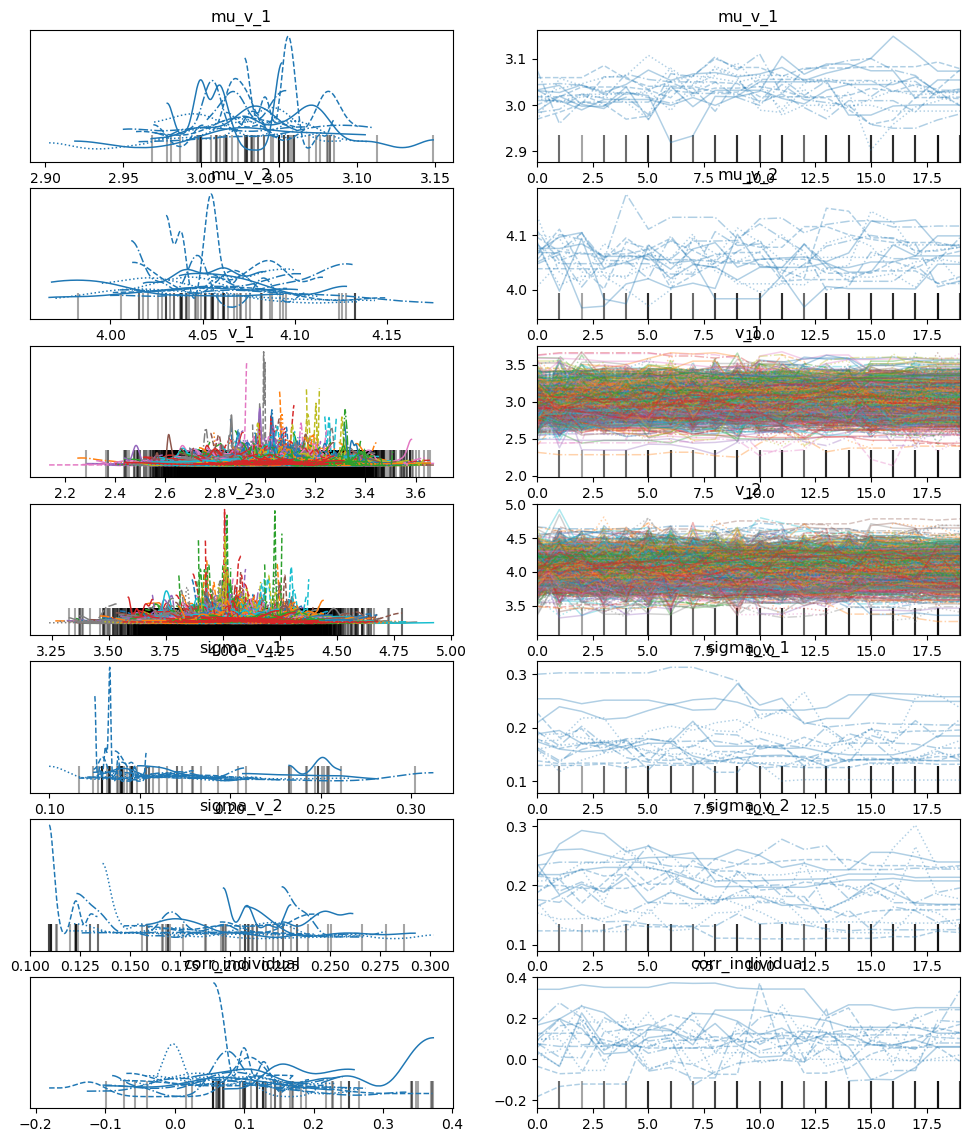

In [2]:
import pymc3 as pm
import numpy as np
import arviz as az

# Number of subjects and samples
num_subjects = 104
num_samples = 10

# Simulate some data for demonstration purposes
np.random.seed(42)
data_session_1 = 3 + np.random.randn(num_subjects, num_samples)
data_session_2 = 2.5 + 0.5 * data_session_1 + np.random.randn(num_subjects, num_samples)

posterior_session_1 = np.load('path_to_your_data/posterior_session_1.npy')
posterior_session_2 = np.load('path_to_your_data/posterior_session_2.npy')


with pm.Model() as hierarchical_model:
    # Hyperpriors for population means and standard deviations
    mu_v_1 = pm.Normal('mu_v_1', mu=0, sd=10)
    sigma_v_1 = pm.HalfNormal('sigma_v_1', sd=10)
    mu_v_2 = pm.Normal('mu_v_2', mu=0, sd=10)
    sigma_v_2 = pm.HalfNormal('sigma_v_2', sd=10)
    
    # Individual subject parameters for each session
    v_1 = pm.Normal('v_1', mu=mu_v_1, sd=sigma_v_1, shape=num_subjects)
    v_2 = pm.Normal('v_2', mu=mu_v_2, sd=sigma_v_2, shape=num_subjects)
    
     # Define likelihood for each subject's data
    for i in range(num_subjects):
        likelihood_1 = pm.Normal('likelihood_1_{}'.format(i), mu=v_1[i], sd=1, observed=data_session_1[i])
        likelihood_2 = pm.Normal('likelihood_2_{}'.format(i), mu=v_2[i], sd=1, observed=data_session_2[i])
    
    # Calculate means
    mean_v1 = pm.math.sum(v_1) / num_subjects
    mean_v2 = pm.math.sum(v_2) / num_subjects
    
    # Calculate covariance and standard deviations
    cov_v1_v2 = pm.math.sum((v_1 - mean_v1) * (v_2 - mean_v2)) / num_subjects
    sd_v1 = pm.math.sqrt(pm.math.sum((v_1 - mean_v1)**2) / num_subjects)
    sd_v2 = pm.math.sqrt(pm.math.sum((v_2 - mean_v2)**2) / num_subjects)
    
    # Calculate correlation
    corr_individual = pm.Deterministic('corr_individual', cov_v1_v2 / (sd_v1 * sd_v2))
    
    # Run MCMC
    trace = pm.sample(20, tune=20, cores=16, chains=16, return_inferencedata=True)

# Save the trace
az.to_netcdf(trace, 'trace_v.nc')

# Check convergence and analyze results
az.plot_trace(trace)
print(az.summary(trace, var_names=['mu_v_1', 'mu_v_2', 'sigma_v_1', 'sigma_v_2', 'corr_individual']))


In [3]:
az.summary(trace, var_names=["rho"])


KeyError: 'var names: "[\'rho\'] are not present" in dataset'

In [45]:
import pymc3 as pm

pm.math.correlation


AttributeError: module 'pymc3.math' has no attribute 'correlation'

In [1]:
np.save('posterior_session_1.npy', list_v1_1)
np.save('posterior_session_2.npy', list_v1_2)


NameError: name 'np' is not defined

In [43]:
combined_samples_session_1 = np.concatenate(list_v1_1)
combined_samples_session_2 = np.concatenate(list_v1_2)
np.shape(list_v1_2)

(104, 20)

In [50]:
import numpy as np
import pymc3 as pm
import arviz as az

# Number of subjects

# Simulate your data here (posterior_session_1 and posterior_session_2)

# Flatten the samples for pymc3
samples_session_1 = np.concatenate(list_v1_1)
samples_session_2 = np.concatenate(list_v1_2)

# Define the Bayesian model
with pm.Model() as model:
    # Priors
    mu_1 = pm.Normal("mu_1", mu=0, sd=10)
    mu_2 = pm.Normal("mu_2", mu=0, sd=10)
    sd_1 = pm.HalfNormal("sd_1", 10)
    sd_2 = pm.HalfNormal("sd_2", 10)
    #rho = pm.Uniform("rho", -1, 1)
    rho = pm.Beta("rho", alpha=2, beta=1)  # Skewed towards 1


    # Transform to covariance matrix
    cov = pm.math.stack([[sd_1**2, rho * sd_1 * sd_2],
                         [rho * sd_1 * sd_2, sd_2**2]])
    
    # Bivariate normal likelihood
    obs = pm.MvNormal("obs", mu=pm.math.stack([mu_1, mu_2]), cov=cov, observed=np.vstack([samples_session_1, samples_session_2]).T)

    # Run MCMC
    trace = pm.sample(20, tune=20, return_inferencedata=True)

# Analyze results
az.summary(trace, var_names=["rho"])


INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [rho, sd_2, sd_1, mu_2, mu_1]


INFO:pymc3:Sampling 4 chains for 20 tune and 20 draw iterations (80 + 80 draws total) took 1 seconds.
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/pymc3/sampling.py:659: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
ERROR:pymc3:There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/arviz/utils.py:187: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rho,0.741,0.235,0.419,0.951,0.075,0.063,8.0,16.0,2.17


In [68]:
np.shape(list_v1_2)

(104, 1000)

In [23]:
# calculating params for all and saving them in a dataframe

param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']
param_data = pd.DataFrame({'Experiment':pd.Series(dtype='str'), 
                               'v1_mean':pd.Series(dtype='float'),'v2_mean':pd.Series(dtype='float'),'zr_mean':pd.Series(dtype='float'),
                               'a_mean':pd.Series(dtype='float'),'ndt_mean':pd.Series(dtype='float'), 'sndt_mean':pd.Series(dtype='float'),
                               'alpha_mean':pd.Series(dtype='float'),
                               'accuracy_percentage':pd.Series(dtype='float'),'mean_log_rt':pd.Series(dtype='float'),
                               'RT_mean_correct_error':pd.Series(dtype='float'),'mean_correct':pd.Series(dtype='float'),                                'mean_Crror':pd.Series(dtype='float'),
                                'error_array':pd.Series(dtype='float'),'RT_Cor_arr':pd.Series(dtype='float'),
                                'q1_C':pd.Series(dtype='float'),'q2_C':pd.Series(dtype='float'),'q3_C':pd.Series(dtype='float'),'q4_C':pd.Series(dtype='float'),
                                'q1_E':pd.Series(dtype='float'),'q2_E':pd.Series(dtype='float'),'q3_E':pd.Series(dtype='float'),'q4_E':pd.Series(dtype='float'),

                            })



for i in file_list : 
    df_1=refine_data_RT(i)
    participant = df_1.nr_part.unique()
    








        
    # in picture drop the first in each block
    if 'picture' in i:
        df = df.drop(df.loc[df['trl_block']==0].index)

    accuracy_percentage = df['acc'].mean()
    RT_mean_correct_error = df['RT'].mean()

    # Step 1: Filter the DataFrame to include only correct responses
    correct_responses = df[df['acc'] == 1]
    unique_points_c = correct_responses['RT'].nunique()

    if unique_points_c >= 4:
        correct_responses['RT_quartile_C'] = pd.qcut(correct_responses['RT'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
        q1_C = np.array(correct_responses[correct_responses['RT_quartile_C']=='Q1']['RT'])
        q2_C = np.array(correct_responses[correct_responses['RT_quartile_C']=='Q2']['RT'])
        q3_C = np.array(correct_responses[correct_responses['RT_quartile_C']=='Q3']['RT'])
        q4_C = np.array(correct_responses[correct_responses['RT_quartile_C']=='Q4']['RT'])


    else:
        correct_responses['RT_quartile_C'] = np.nan  # Assign NaN when not enough unique data points
        q1_C = np.nan
        q2_C = np.nan
        q3_C = np.nan
        q4_C = np.nan

    # Check if there are enough unique points to create quartiles
   
    RT_Cor_arr = correct_responses['RT']
    
    error_responses = df[df['acc'] == 0]
    unique_points = error_responses['RT'].nunique()
    if unique_points >= 4:
        error_responses['RT_quartile_E'] = pd.qcut(error_responses['RT'], 4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
        q1_E = np.array(error_responses[error_responses['RT_quartile_E']=='Q1']['RT'])
        q2_E = np.array(error_responses[error_responses['RT_quartile_E']=='Q2']['RT'])
        q3_E = np.array(error_responses[error_responses['RT_quartile_E']=='Q3']['RT'])
        q4_E = np.array(error_responses[error_responses['RT_quartile_E']=='Q4']['RT'])


    else:
        error_responses['RT_quartile_E'] = np.nan  # Assign NaN when not enough unique data points
        q1_E = np.nan
        q2_E = np.nan
        q3_E = np.nan
        q4_E = np.nan


    error_array = error_responses['RT']
    mean_correct = correct_responses['RT'].mean()
    mean_error =error_responses['RT'].mean()
    # Step 2: Apply the natural logarithm transformation
    log_transformed_rt_correct = np.log((correct_responses['RT']*1000))
    # Step 3: Calculate the mean of these logarithmized response times
    mean_log_rt = log_transformed_rt.mean()
    
    data_rts=np.array(model_compatiabel_data(df))
    
    #considering the configurator 
    out={}
    
    out['summary_conditions'] = data_rts.reshape( 1, data_rts.shape[0],2)
    non_batch_context=np.array([data_rts[data_rts[:,1]==1].shape[0],data_rts[data_rts[:,1]==0].shape[0]])
    N = np.log(non_batch_context)
    N_vec = N * np.ones((1, 1), dtype=np.float32)
    out['direct_conditions'] = N_vec
    
    
    
    posterior_draws = amortizer.sample(out,n_samples=1000)
    post_samples = prior_means + posterior_draws * prior_stds
    
    v1_mean = post_samples[:,0].mean()
    v2_mean = post_samples[:,1].mean()
    zr_mean = post_samples[:,2].mean()
    a_mean=post_samples[:,3].mean()
    ndt_mean=post_samples[:,4].mean()
    sndt_mean= post_samples[:,5].mean()
    alpha_mean=post_samples[:,6].mean()
    
    
    

    
    #get everything after last slash
    file_name = i.rsplit('/',1)[-1]
    
    param_data.loc[len(param_data)] = [file_name, v1_mean,v2_mean,zr_mean,a_mean,ndt_mean,sndt_mean,alpha_mean,
                                       accuracy_percentage,mean_log_rt,RT_mean_correct_error,mean_correct,
                                      mean_error,error_array,RT_Cor_arr,
                                      q1_C,q2_C,q3_C,q4_C,
                                      q1_E,q2_E,q3_E,q4_E,]
    
    
    
    
    
    
    
    
    
        
    


/tmp/ipykernel_431359/3454878908.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  refined_df = pd.read_csv(file_name, sep='\s+|\s+')


NameError: name 'df' is not defined

In [61]:
df=rt_mean_all_par

In [62]:
df_word_part_1 = df[df['Experiment'].str.contains('class_words_part_1.')]
df_word_part_2 = df[df['Experiment'].str.contains('class_words_part_2.')]
df_word_part_2

,Experiment,rt_mean,acc_rate
1,1025_class_words_part_2.dat,0.589127,0.977500
5,1018_class_words_part_2.dat,0.565233,0.977500
9,015_class_words_part_2.dat,0.660065,0.935000
11,3010_class_words_part_2.dat,0.740875,0.947500
16,4003_class_words_part_2.dat,0.738160,0.977444
...,...,...,...
389,4008_class_words_part_2.dat,0.682716,0.935135
392,011_class_words_part_2.dat,0.552938,0.965000
398,1001_class_words_part_2.dat,0.627193,0.952500
403,019_class_words_part_2.dat,0.705590,0.923077


In [63]:
df_word_part_1=df_word_part_1.sort_values('Experiment')
df_word_part_2=df_word_part_2.sort_values('Experiment')

In [64]:
import pandas as pd
import scipy.linalg as sp
import numpy as np
def mahalanobis(x=None, data=None, cov=None):
    """Compute the Mahalanobis Distance between each row of x and the data  
    x    : vector or matrix of data with, say, p columns.
    data : ndarray of the distribution from which Mahalanobis distance of each observation of x is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    """
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = sp.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

In [65]:
from scipy.stats import pearsonr
from scipy.stats import chi2
chi2.ppf((1-0.001), df=2)
#> 9.21


13.815510557964274

In [ ]:
params_mean=['rt_mean','acc_rate']
#corr_frame['Experiment']=df_word_part_1['Experiment']
final_corr_frame = pd.DataFrame()
final_corr_frame['Experiment']=['class_words']
final_corr_frame['corr_type']=['between session']

final_corr_dict = {}
from scipy.stats import chi2
chi2.ppf((1-0.001), df=2)

for param in params_mean:
    corr_frame = pd.DataFrame()
    par_1='param_1_'+str(param)
    par_2='param_2_'+str(param)
    data_analysis = {'Experiment':df_word_part_1['Experiment'],par_1:np.array(df_word_part_1[param]),par_2:np.array(df_word_part_2[param])}
    corr_frame = pd.DataFrame(data_analysis)    
    df_x = corr_frame[[par_1, par_2]]
    df_x['mahala'] = mahalanobis(x=df_x, data=corr_frame[[par_1, par_2]])
    df_x['p_value'] = 1 - chi2.cdf(df_x['mahala'], 2)

# Extreme values with a significance level of 0.01
    df_outliers=df_x.loc[df_x.p_value < 0.001]
    ind=df_outliers.index
#drop the outliers with index     
    corr_without_outlier = corr_frame.drop(ind)
    x = corr_without_outlier[par_1]
    y = corr_without_outlier[par_2]
    corr =  np.corrcoef(x, y)[0,1]
    print(param)
    plt.plot(x, y, '.', color='black')
    plt.show()
    
    final_corr_frame['corr_'+str(param)] = [corr]

#saving the results 

final_corr_frame.to_csv('corr_between_session_word_class.csv',index=False)
 
    


In [24]:
#num_val = 300
#val_sims = generative_model(num_val)
#val_sims

In [25]:
#h = trainer.train_online(epochs=5, iterations_per_epoch=1000, batch_size=128, validation_sims=val_sims)

In [26]:
#f = bf.diagnostics.plot_losses(h['train_losses'], h['val_losses'])

# Validation Phase
## Inspecting the Latent Space

In [27]:
#f = trainer.diagnose_latent2d()

# Simulation-Based Calibration - Rank Histograms

In [86]:
def prior_N(n_min=100, n_max=100):
    """A prior fo]r the number of observation (will be called internally at each backprop step)."""
    return  np.random.randint(n_min, n_max+1, 2)

In [142]:
num_test = 1000
num_posterior_draws_recovery = 5000
new_sims = configurator(generative_model(num_test))

In [143]:
new_sims['summary_conditions'].shape


(1000, 1000, 2)

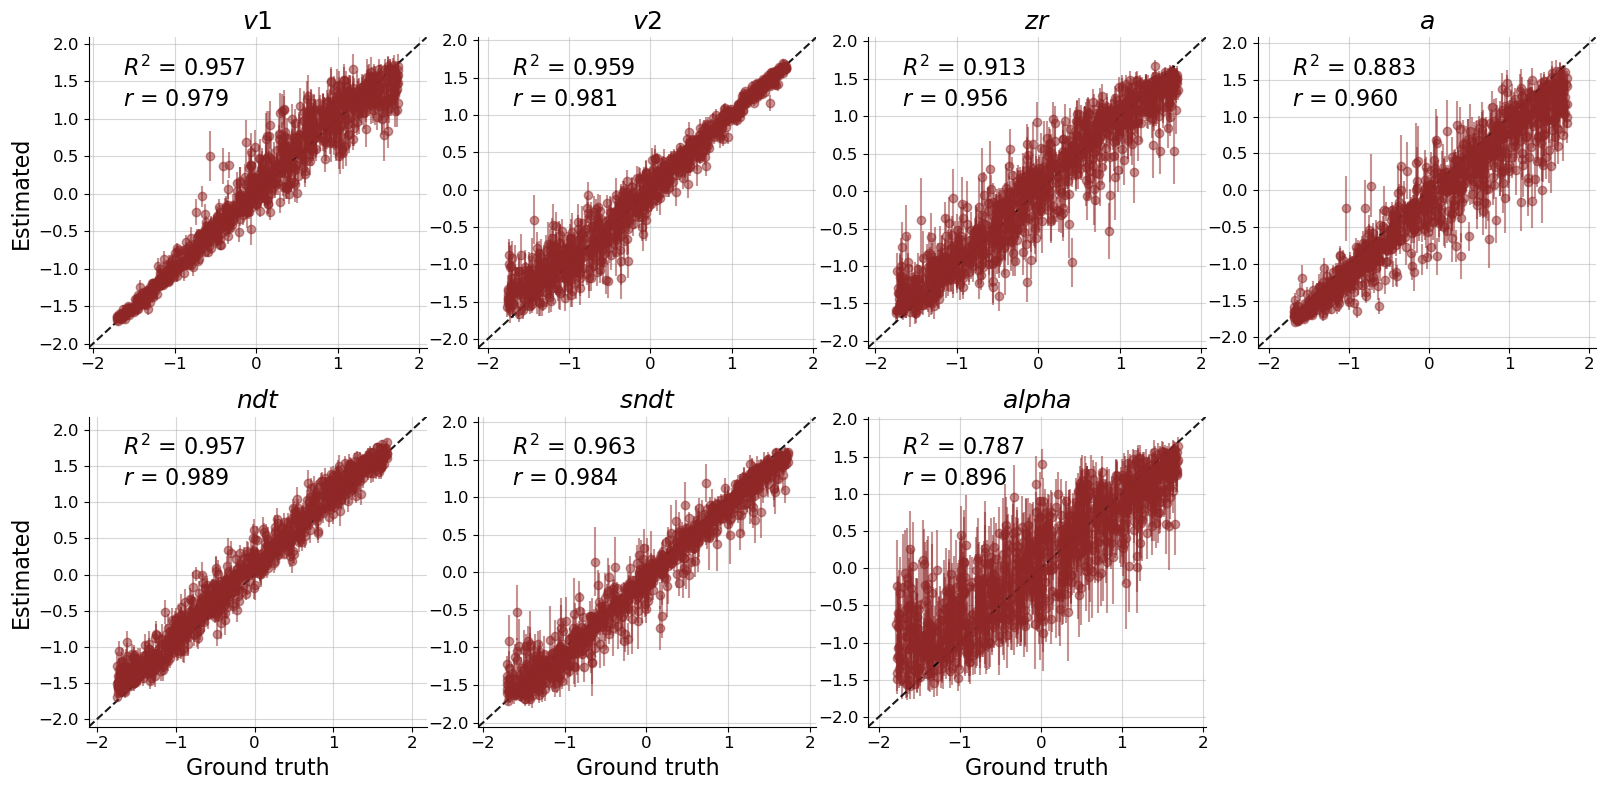

In [144]:
posterior_draws = amortizer.sample(new_sims, n_samples=num_posterior_draws_recovery)
fig = bf.diagnostics.plot_recovery(posterior_draws, new_sims['parameters'],param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])

IndexError: unsupported iterator index

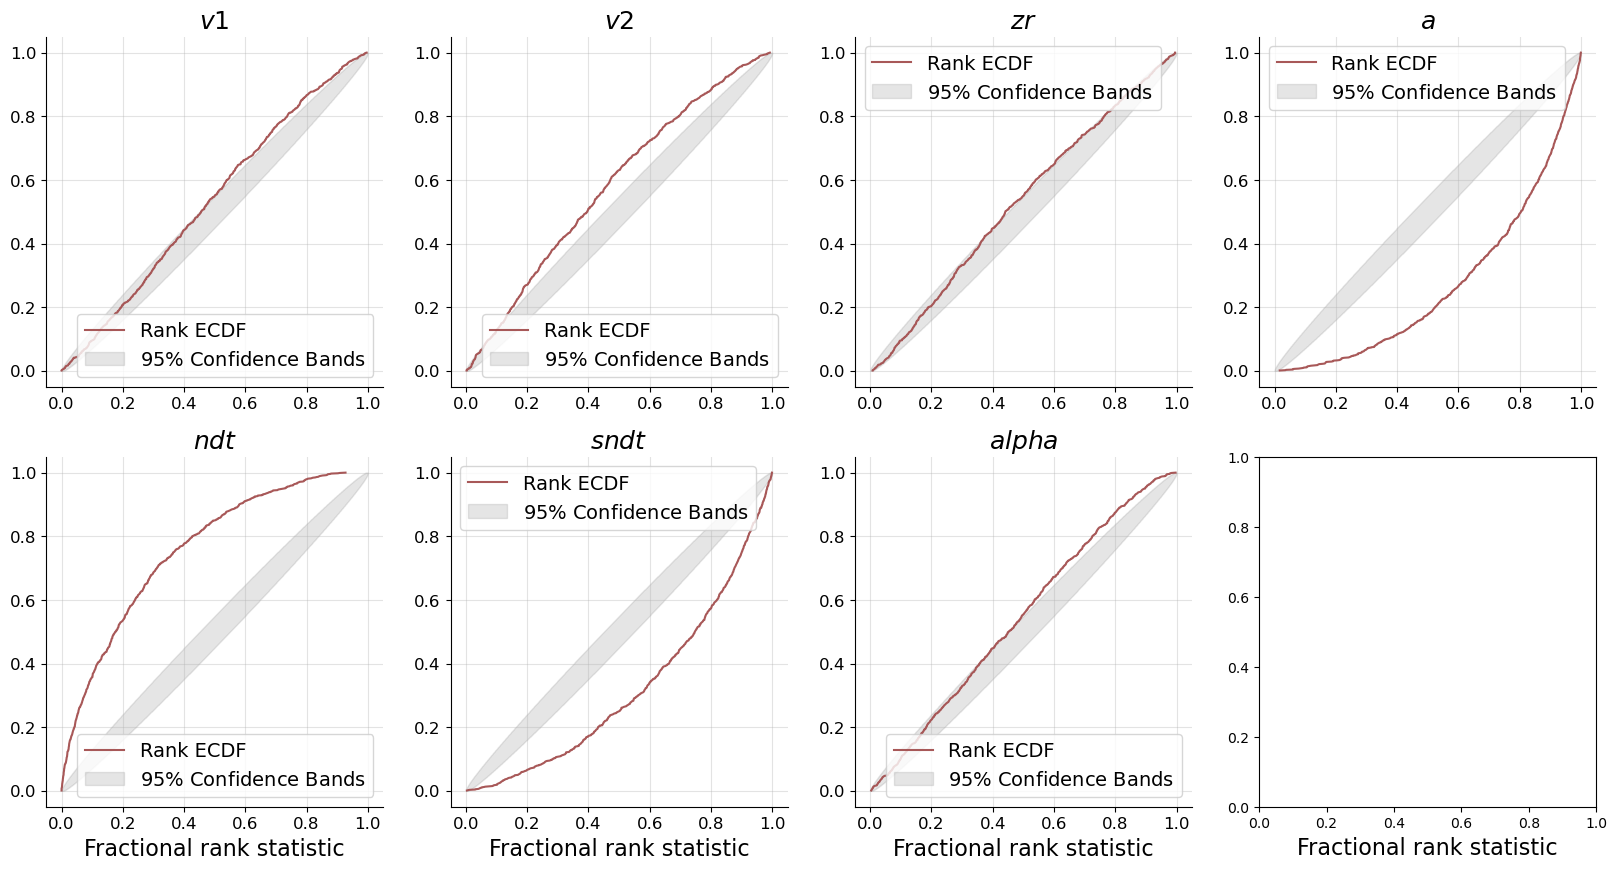

In [145]:
#posterior_draws = amortizer.sample(new_sims, n_samples=100)
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'],param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])

In [ ]:
f = bf.diagnostics.plot_sbc_ecdf(posterior_draws, new_sims['parameters'], stacked=True, 
                       difference=True, legend_fontsize=12, fig_size=(10, 8))

In [ ]:
posterior_draws = amortizer.sample(new_sims, n_samples=50)
f = bf.diagnostics.plot_sbc_histograms(posterior_draws, new_sims['parameters'], num_bins=10,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])

ValueError: cannot reshape array of size 50000 into shape (1000,5000,1)

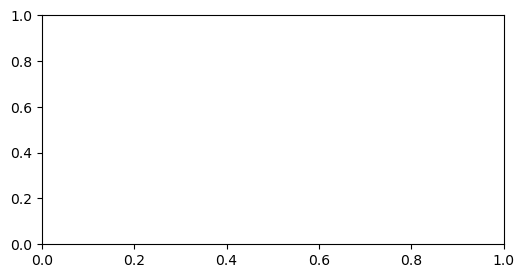

In [52]:
#posterior_draws = amortizer.sample(new_sims, n_samples=num_posterior_draws_recovery)
# Michael Nunez's recovery function
def recovery(possamps, truevals):  # Parameter recovery plots
    """Plots true parameters versus 99% and 95% credible intervals of recovered
    parameters. Also plotted are the median (circles) and mean (stars) of the posterior
    distributions.

    Parameters
    ----------
    possamps : ndarray of posterior chains where the last dimension is the
    number of chains, the second to last dimension is the number of samples in
    each chain, all other dimensions must match the dimensions of truevals

    truevals : ndarray of true parameter values
    """

    # Number of chains
    nchains = possamps.shape[-1]

    # Number of samples per chain
    nsamps = possamps.shape[-2]

    # Number of variables to plot
    nvars = np.prod(possamps.shape[0:-2])

    # Reshape data
    alldata = np.reshape(possamps, (nvars, nchains, nsamps))
    alldata = np.reshape(alldata, (nvars, nchains * nsamps))
    truevals = np.reshape(truevals, (nvars))

    # Plot properties
    LineWidths = np.array([2, 5])
    teal = np.array([0, .7, .7])
    blue = np.array([0, 0, 1])
    orange = np.array([1, .3, 0])
    Colors = [teal, blue]

    for v in range(0, nvars):
        # Compute percentiles
        bounds = stats.scoreatpercentile(alldata[v, :], (.5, 2.5, 97.5, 99.5))
        for b in range(0, 2):
            # Plot credible intervals
            credint = np.ones(100) * truevals[v]
            y = np.linspace(bounds[b], bounds[-1 - b], 100)
            lines = plt.plot(credint, y)
            plt.setp(lines, color=Colors[b], linewidth=LineWidths[b])
            if b == 1:
                # Mark median
                mmedian = plt.plot(truevals[v], np.median(alldata[v, :]), 'o')
                plt.setp(mmedian, markersize=10, color=[0., 0., 0.])
                # Mark mean
                mmean = plt.plot(truevals[v], np.mean(alldata[v, :]), '*')
                plt.setp(mmean, markersize=10, color=teal)
    # Plot line y = x
    tempx = np.linspace(np.min(truevals), np.max(
        truevals), num=100)
    recoverline = plt.plot(tempx, tempx)
    plt.setp(recoverline, linewidth=3, color=orange)


# Plot the results
fig=plt.figure(figsize=(15,8), tight_layout=True)

columns = 3
rows = 3
param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']
for i in range(len(param_names)):
    
    fig.add_subplot(rows, columns, i+1)
    recovery(posterior_draws[:, :, i].reshape(num_test, num_posterior_draws_recovery, 1), new_sims['parameters'][:, i].squeeze())
    plt.xlabel('Grand truth', fontsize=16)
    plt.ylabel('Posterior', fontsize=16)
    plt.title(param_names[i], fontsize=16)
    if i==0:
        plt.legend(['99% CI','95% CI','Median', 'Mean'], fontsize=11, loc = 'upper left')




In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import r2_score
param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$']
def compute_performance_metrics(model, n_points_grid, param_names, 
                                 n_sim=20, n_test=300, n_samples=2000, transform=None):
    """
    Compute metrics for different numbers of datapoints.
    ---------

    Arguments:
    model           : tf.keras.Model -- the invertible chaoin with an optional summary net
                                        both models are jointly trained
    param_names     : list of strings -- the names of the parameters
    simulate_fun    : callable -- the simulate function
    n_test          : number of test datasets
    n_samples       : number of samples from the approximate posterior
    transform       : callable ot None -- a function to transform X and theta, if given
    ----------

    Returns:
    metrics : dict -- a dictionary with the metrics
    """

    metrics = {
        'rmse':  {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'nrmse': {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'r2':    {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names},
        'std':   {k: np.zeros((n_points_grid.shape[0], n_sim)) for k in param_names}
    }
    
    with tqdm(total=n_points_grid.shape[0]) as p_bar:
        for n, n_points in enumerate(n_points_grid):
            def prior_N(n_min=n_points, n_max=n_points):
                return np.random.randint(n_min, n_max+1)
            p_bar.set_postfix_str("Simulating with N={}".format(n_points))
            for si in range(n_sim):
                
                # Simulate data 
                prior = bf.simulation.Prior(prior_fun=draw_prior,param_names=[r'$v1$',r'$v2$',r'$zr$', r'$a$', r'$ndt$',r'$sndt$',r'$alpha$'])
                var_num_obs = bf.simulation.ContextGenerator(non_batchable_context_fun=prior_N)
                simulator = bf.simulation.Simulator(simulator_fun=sim_v2.simulate_diffusion_2_conds, context_generator=var_num_obs)
                generative_model = bf.simulation.GenerativeModel(prior,simulator,name='v2_equiv')
                
                x = configurator(generative_model(n_test))
                theta_test_s , X_test_s = x['parameters'] , x['summary_conditions']
                
               # X_test_s, theta_test_s = simulate_fun(n_test, n_points=n_points)
               # if transform is not None:
               #     X_test_s, theta_test_s = transform(X_test_s, theta_test_s)
               # theta_test_s = theta_test_s.numpy()

                # Sample from posterior and compute mean and variance
                posterior_draws = model.sample(x, n_samples=n_samples)
                theta_test_hat = posterior_draws.mean(1)
                theta_test_std = posterior_draws.std(axis=1, ddof=1)

                
                #theta_samples = model.sample(X_test_s, n_samples=n_samples, to_numpy=True)
                #theta_test_hat = theta_samples.mean(0)
                #theta_test_std = theta_samples.std(axis=0, ddof=1)

                # --- Plot true vs estimated posterior means on a single row --- #
                for k, name in enumerate(param_names):

                    # Compute NRMSE
                    rmse = np.sqrt(np.mean( (theta_test_hat[:, k] - theta_test_s[:, k])**2 ))
                    nrmse = rmse / (theta_test_s[:, k].max() - theta_test_s[:, k].min())

                    # Compute R2
                    r2 = r2_score(theta_test_s[:, k], theta_test_hat[:, k])

                    # Extract mean posterior std
                    std = np.mean(theta_test_std[:, k])

                    # Add to dict
                    metrics['rmse'][name][n, si] = rmse
                    metrics['nrmse'][name][n, si] = nrmse
                    metrics['r2'][name][n, si] = r2
                    metrics['std'][name][n, si]  = std
            p_bar.update(1)
        return metrics


In [ ]:
n_points_grid=np.arange(100, 1001, 10)

metrics = compute_performance_metrics(amortizer, 
                    n_points_grid, 
                    param_names=param_names, 
                    #simulate_fun=data_generator,
                    n_sim=10, 
                    n_test=300, 
                    n_samples=2000)
                    #transform=transform)

In [ ]:
def plot_performance_metrics(metrics, n_points_grid, param_names, figsize=(12, 4), show=True, 
                             xlabel=r'$n$', filename=None, legend_loc=None, std_ci=2, font_size=12):
    
    """Plots specified metrics over ns."""

    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Initialize figure
    f, axarr = plt.subplots(1, 2, figsize=figsize)

    for i, metric in enumerate(['nrmse', 'r2']):
        for p in param_names:

            metric_mean = metrics[metric][p].mean(axis=1)
            metric_std = metrics[metric][p].std(axis=1, ddof=1)

            axarr[i].plot(n_points_grid, metric_mean, label=p, lw=2)
            axarr[i].fill_between(n_points_grid, 
                            metric_mean-std_ci*metric_std, 
                            metric_mean+std_ci*metric_std, 
                            interpolate=True, alpha=0.2)

        if metric == 'nrmse':
            axarr[i].set_ylabel('NRMSE')
        elif metric == 'r2':
            axarr[i].set_ylabel(r'$R^{2}$')
        axarr[i].set_xlabel(xlabel)

        axarr[i].spines['right'].set_visible(False)
        axarr[i].spines['top'].set_visible(False)
        if legend_loc is not None:
            axarr[i].legend(loc=legend_loc[i], fontsize=10)
        else:
            axarr[i].legend(fontsize=12)

    f.tight_layout()
    
    if show:
        plt.show()
    
    if filename is not None:
        f.savefig("figures/{}_metrics.png".format(filename), dpi=600, bbox_inches='tight')



In [ ]:
plot_performance_metrics(metrics, 
                         n_points_grid, 
                         param_names, 
                         legend_loc=['upper right', 'lower right'],
                         xlabel=r'Number of trials ($N$)', 
                         figsize=(12, 6),
                         filename='Levy_Metrics')

In [ ]:
x = configurator(generative_model(32))
theta_test_s , X_test_s = x['parameters'] , x['summary_conditions']

In [ ]:
X_test_s.shape

In [ ]:
n_samples  = 1000
posterior_draws = amortizer.sample(x, n_samples=num_posterior_draws_recovery)
#theta_samples = amortizer.sample(X_test_s, n_samples=n_samples)

In [ ]:
posterior_draws.shape

In [ ]:
theta_test_hat = posterior_draws.mean(1)
theta_test_std = posterior_draws.std(axis=1, ddof=1)


In [ ]:
theta_test_hat.shape

In [ ]:
theta_test_hat

In [ ]:
theta_test_std.shape

In [ ]:
theta_test_std

In [ ]:
r2 = r2_score(theta_test_s[:,1], theta_test_hat[:,1])

In [ ]:
r2 = r2_score(theta_test_s[:,2], theta_test_hat[:,2])
r2

In [ ]:
r2

In [ ]:
r2 = r2_score(theta_test_s[:, k], theta_test_hat[:, k])

In [ ]:
theta_test_s.shape

In [ ]:
n_points_grid=np.arange(100, 121, 10)
for n, n_points in enumerate(n_points_grid):
    print (n_points)

In [ ]:
n_points_grid=np.arange(100, 121, 10)
metrics = compute_performance_metrics(amortizer, 
                    n_points_grid, 
                    param_names=param_names, 
                    simulate_fun=data_generator,
                    n_sim=10, 
                    n_test=300, 
                    n_samples=2000
                    )

In [ ]:
f = bf.diagnostics.plot_posterior_2d(single_pp,param_names=prior.param_names)

In [ ]:
f = bf.diagnostics.plot_posterior_2d(single_pp, prior=prior)

In [ ]:
import matplotlib.pyplot as plt

def plot_ppc(config, post_samples, logscale=True, color='Blue', 
                            dummy=True, figsize=(12, 6), font_size=18):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    # Remove parameters < 0
    samples = post_samples[np.sum(post_samples < 0, axis=1) == 0]
    
    f, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Re-simulations
    sims = []
    for i in range(samples.shape[0]):  
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim 
        sim_cases = stationary_SIR(samples[i], config['N'], config['T'])[:, 0]
        sims.append(sim_cases)
    sims = np.array(sims)
    
    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)
    
    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), label='Median predicted cases', color=color)
    ax.plot(config['obs_data'], marker='o', label='Reported cases', color='black', linestyle='dashed', alpha=0.8)
    
    # Add compatibility intervals (also called credible intervals)
    ax.fill_between(range(config['T']), qs_50[0], qs_50[1], color=color, alpha=0.3, label='50% CI')
    ax.fill_between(range(config['T']), qs_90[0], qs_90[1], color=color, alpha=0.2, label='90% CI')
    ax.fill_between(range(config['T']), qs_95[0], qs_95[1], color=color, alpha=0.1, label='95% CI')
    
    # Grid and schmuck
    ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Days since pandemic onset')
    ax.set_ylabel('Number of cases')
    ax.minorticks_off()
    if logscale:
        ax.set_yscale('log')
    ax.legend(fontsize=font_size)
    return f

In [ ]:
f = plot_ppc(config, post_samples)
